In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, resample


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [2]:
df = pd.read_csv('lang_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2839 entries, 0 to 2838
Data columns (total 2 columns):
text        2761 non-null object
language    2839 non-null object
dtypes: object(2)
memory usage: 44.5+ KB


In [4]:
df.describe()

,text,language
count,2761,2839
unique,2752,3
top,As different as chalk and cheese,English
freq,2,2077


In [5]:
df.isnull().sum()

text        78
language     0
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.describe()

,text,language
count,2752,2752
unique,2752,3
top,Half-cocked,English
freq,1,2047


In [9]:
df.head()

,text,language
0,Ship shape and Bristol fashion,English
1,Know the ropes,English
2,Graveyard shift,English
3,Milk of human kindness,English
4,Touch with a barge-pole - Wouldn't,English


In [10]:
# rename columns to something better
df.columns = ['data', 'labels']
df.data = df.data.astype(str)

In [11]:
# Shuffle to eliminate possible segreggation
# Random state to keep hold-out test set consistent
df = shuffle(df, random_state=0)

In [12]:
# 10% test set never to be touched till handin
df = df[:int(-0.1*len(df))]
len(df)

2477

In [13]:
# create binary labels
df['b_labels'] = df['labels'].map({'English': 0, 'Afrikaans': 1, 'Nederlands': 2})

In [14]:
# split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], df['b_labels'], test_size=0.33, random_state = 42)

In [15]:
train_df = pd.concat([Ytrain, df_train], axis=1, join='inner')
train_df['b_labels'].value_counts()

0    1241
1     373
2      45
Name: b_labels, dtype: int64

In [16]:
class0 = train_df[train_df['b_labels'] == 0]
class1 = train_df[train_df['b_labels'] == 1]
class2 = train_df[train_df['b_labels'] == 2]
max = train_df['b_labels'].value_counts().max()

if len(train_df[train_df['b_labels'] == 0]) == max:
    majority = class0
    minority1 = class1
    minority2 = class2
elif len(train_df[train_df['b_labels'] == 1]) == max:
    minority1 = class0
    majority = class1
    minority2 = class2
else:
    minority1 = class0
    minority2 = class1
    majority = class2

In [17]:
new_minority1 = resample(minority1, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

new_minority2 = resample(minority2, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority1])
train_df = pd.concat([train_df, new_minority2])
train_df = shuffle(train_df, random_state=42)

train_df['b_labels'].value_counts()

1    1241
2    1241
0    1241
Name: b_labels, dtype: int64

In [18]:
Ytrain = train_df['b_labels']
df_train= train_df['data']

In [19]:
Ytrain = pd.get_dummies(Ytrain).values
Ytest = pd.get_dummies(Ytest).values

In [20]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [21]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 3157 unique tokens.


In [22]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (3723, 65)


In [23]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (818, 65)


In [24]:
# Embedding dimensionality
D = 20

# Hidden state dimensionality
M = 15

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(3, activation='softmax')(x)

model = Model(i, x)

In [25]:
# Compile and fit
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  Ytrain,
  epochs=10,
  validation_data=(data_test, Ytest)
)

Training model...
Train on 3723 samples, validate on 818 samples
Epoch 1/10
3723/3723 [==============================] - 6s 1ms/sample - loss: 0.9333 - accuracy: 0.7575 - val_loss: 0.8241 - val_accuracy: 0.9523
Epoch 2/10
3723/3723 [==============================] - 1s 291us/sample - loss: 0.3586 - accuracy: 0.9809 - val_loss: 0.3207 - val_accuracy: 0.9548
Epoch 3/10
3723/3723 [==============================] - 1s 289us/sample - loss: 0.1247 - accuracy: 0.9890 - val_loss: 0.1831 - val_accuracy: 0.9694
Epoch 4/10
3723/3723 [==============================] - 1s 289us/sample - loss: 0.0630 - accuracy: 0.9970 - val_loss: 0.1407 - val_accuracy: 0.9707
Epoch 5/10
3723/3723 [==============================] - 1s 288us/sample - loss: 0.0382 - accuracy: 0.9995 - val_loss: 0.1155 - val_accuracy: 0.9743
Epoch 6/10
3723/3723 [==============================] - 1s 310us/sample - loss: 0.0261 - accuracy: 1.0000 - val_loss: 0.1005 - val_accuracy: 0.9756
Epoch 7/10
3723/3723 [===========================

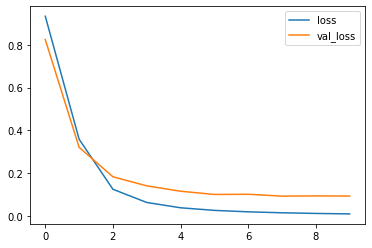

In [26]:
# Loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

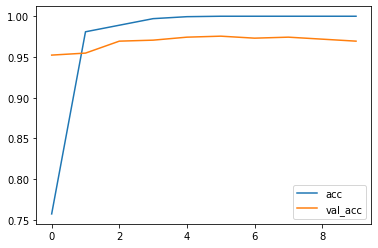

In [27]:
# Accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

Normalized confusion matrix
[[0.99666667 0.00333333 0.        ]
 [0.05527638 0.92964824 0.01507538]
 [0.36842105 0.10526316 0.52631579]]


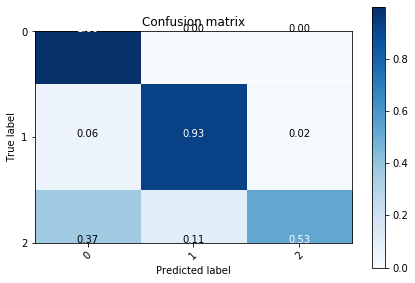

In [29]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


p_test = model.predict(data_test).argmax(axis=1)
Ytest = np.argmax(Ytest, axis=1)
cm = confusion_matrix(Ytest, p_test)
plot_confusion_matrix(cm, list(range(3))) 